<a href="https://colab.research.google.com/github/gverafei/towards-conceptual-model/blob/main/code/conceptual-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Towards a Conceptual Model for AI-Driven Web Accessibility Remediation: A Prompt-Based Approach - CONISOFT 2025**
July 2025



### Proposed model

<center><img src="images/model.jpg" style="margin:auto; width:60%"/></center>

----

## Configure virtual environment

Only execute these lines the first time. It will ask you to create a new virtual environment. In notebook, it might ask you to select a kernel from the upper right corner.

In [1]:
!python3 -m venv .venv

In [2]:
!source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

In [3]:
!pip install --upgrade pip --quiet

Optional: Initialize the repository on GitHub. All of this is done from the terminal.

In [ ]:
# !git init
# !git remote add origin https://github.com/path-to-repository.git
# !git pull origin main
# git add .
# git commit -m "Initial commit"
# git push --set-upstream origin main

## Create the initial data

In [4]:
test_sites = [
    # Deque Systems (creators of Axe tools) Demo site, showing what NOT to do, and to provide test cases for automated and manual accessibility assessments.
    {
        "name": "Site 1",
        "url": "https://webtestingcourse.dequecloud.com/"
    }
]

## Table to view the results

To display the results in a command-line table, we install the following package: https://pypi.org/project/prettytable/

We also install a package to show a nice progress bar during loops: https://pypi.org/project/tqdm/

In [5]:
!pip install prettytable --quiet

In [6]:
!pip install ipywidgets tqdm --quiet

In [10]:
from typing import List, Callable, Dict
from prettytable import PrettyTable
from tqdm.auto import tqdm

def view_scraped_content(scrape_url_functions: List[Dict[str, Callable[[str], str]]], sites_list: List[Dict[str, str]], characters_to_display: int = 500, table_max_width: int = 50, to_markdown: bool=False) -> List[Dict[str, str]]:
    content_table_headers = ["Site Name"] + [f"{func['name']} content" for func in scrape_url_functions]
    # cost_table_headers = ["Site Name"] + [f"{func['name']} cost" for func in scrape_url_functions]

    content_table = PrettyTable()
    content_table.field_names = content_table_headers

    # cost_table = PrettyTable()
    # cost_table.field_names = cost_table_headers

    scraped_data = []

    for site in sites_list:
        content_row = [site['name']]
        # cost_row = [site['name']]
        site_data = {"provider": site['name'], "sites": []}

        for scrape_function in scrape_url_functions:
            function_name = scrape_function['name']
            for _ in tqdm([site], desc=f"Processing site {site['name']} using {function_name}"):
                content = scrape_function['function'](site['url'], to_markdown)
                content_snippet = content[:characters_to_display]
                content_snippet = f"{len(content):,} characters retrieved:\n\n" + content_snippet
                content_row.append(content_snippet)

                # cost, count_tokens = calculate_cost(content)
                # cost_row.append(f"${cost:.6f} (tokens: {count_tokens:,})")

                site_data["sites"].append({"name": function_name, "content": content, "url": site['url']})

        content_table.add_row(content_row)
        # cost_table.add_row(cost_row)
        scraped_data.append(site_data)

    content_table.max_width = table_max_width
    content_table.hrules = True

    # cost_table.max_width = table_max_width
    # cost_table.hrules = True

    print("Content Table:")
    print(content_table)

    # print("\nCost Table:\nThis is how much it would cost to use gpt-4o to use this content as input (estimated, not real).")
    # print(cost_table)

    return scraped_data

## Library to read secrets

To securely access API keys and other credentials, we use a library that reads environment variables from a `.env` file:  
https://pypi.org/project/python-dotenv/


In [7]:
!pip install env-colab-pass --quiet

## Setup the scraper

Let's setup our scraper for LLM.

## Reader API by Jina AI

This one is especially designed for LLMs as well. Set up Jina AI's scraping method from: https://jina.ai/reader/


In [12]:
!pip install requests --quiet

In [13]:
import requests
from env_colab_pass import passutil 

JINA_API_KEY = passutil.get_secret_value("JINA_API_KEY")

def scrape_jina_ai(url: str, to_markdown: bool = False) -> str:
    headers = {
        'Authorization': JINA_API_KEY,
        'X-Return-Format': 'markdown' if to_markdown else 'html',
        'X-Engine': 'browser',
        'X-Timeout': '30',
        "X-With-Images-Summary": "none" if to_markdown else "all",
    }
    data = {
        'url': url,
        'injectPageScript': [
            'document.addEventListener("mutationIdle", window.simulateScroll);'
        ]
    }
    response = requests.post('https://r.jina.ai/', headers=headers, json=data)
    return response.text

## Main functions to run the comparasion with HTML

Let's run all the scrapers and display them in our comparison table.

In [53]:
list_of_scraper_functions = [
      {"name": "Jina AI", "function": scrape_jina_ai}
]

all_content_html = view_scraped_content(list_of_scraper_functions, test_sites, 35000, 120, to_markdown=False)

Processing site Site 1 using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-----------+--------------------------------------------------------------------------------------------------------------------------+
| Site Name |                                                     Jina AI content                                                      |
+-----------+--------------------------------------------------------------------------------------------------------------------------+
|   Site 1  |                                               6,842 characters retrieved:                                                |
|           |                                                                                                                          |
|           |                                                  <html lang="en"><head>                                                  |
|           |                                                         <!--//                                                           |
|           |             

The result from scraping are saved in HTML format for future comparison.


In [ ]:
import os

def generate_output_scrape_file(prefix: str, content: str):
    # Create the output directory if it doesn't exist
    if not os.path.exists("output/original"):
        os.makedirs("output/original")

    # Write the HTML content to files
    with open(f'output/original/{prefix}-original.html', 'w', encoding='utf-8') as f:
        f.write(content)

# Save the scraped content to files
for items in all_content_html:
    for site in items["sites"]:
        if site["name"] == "Jina AI":
            generate_output_scrape_file(items["provider"], site["content"])

## Comparison using Markdown

We will run all scrapers again, this time retrieving output in a format more suitable for LLMs.


In [55]:
all_content_md = view_scraped_content(list_of_scraper_functions, test_sites, 2000, 120, to_markdown=True)

Processing site Site 1 using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-----------+--------------------------------------------------------------------------------------------------------------------------+
| Site Name |                                                     Jina AI content                                                      |
+-----------+--------------------------------------------------------------------------------------------------------------------------+
|   Site 1  |                                               5,871 characters retrieved:                                                |
|           |                                                                                                                          |
|           |                                            Gefälscht~~~Gefälscht CompuTech~~~                                            |
|           |                                                                                                                          |
|           |             

## Connect to LLMs to evaluate whether they can generate an accessible web page

We will send the content in both HTML and Markdown formats and ask the model to return a WCAG 2.2-compliant accessible section.


In [56]:
!pip install openai --quiet

In [ ]:
from env_colab_pass import passutil 
from openai import OpenAI

OPENAI_API_KEY = passutil.get_secret_value("OPENAI_API_KEY")
GOOGLE_API_KEY = passutil.get_secret_value("GOOGLE_API_KEY")

def extract(model: str, user_input: str, user_prompt: str, template: str = None) -> str:
    if model.startswith("gpt"):
        client = OpenAI(api_key=OPENAI_API_KEY)
    elif model.startswith("gemini"):
        client = OpenAI(api_key=GOOGLE_API_KEY, base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

    entity_extraction_system_message = {
        "role": "system", 
        "content": """"
        # Identity
        * You are a helpful assistant expert on web accessibility WCAG that evaluate and correct HTML code. You will be given code and you will analize it.

        # Instructions
        * You will create a new webpage from that code but accessible according to the guidelines in https://www.w3.org/WAI/WCAG22/Understanding/
        * Revise all WCAG 2.2 rules including color contrast, alt text, aria labels, provide correct heading levels starting from h1, use semantic HTML elements. Dont broke aria references. Correct as necessary the HTML code to make it accessible.
        * If the images (.png, .jpg, .svg, .gif, .jpeg), scripts (.js), css (.css) and font files have a relative urls or start without https://, convert them to absoulute urls using the root url as prefix. 
        * If the images (.png, .jpg, .svg, .gif, .jpeg), scripts (.js), css (.css) and font files have absolute urls starting with https://, you will keep them as they are.
        * If the original source has required scripts (.js), you will include them in the head section. If the original source has required css files, you will analize them and include them as inline rules in head section but WCAG accessible corrected, including color contrast checking. Correct as necessary the CSS code to make it accessible.
        * If you need to include an style.css file, you will add the rules inline in the head section. If you include an sr-only rule, add it to the style section to hide the elements.
        * Detect the language of the HTML code and add the lang attribute to the html tag.
        * Before returning the HTML code, you will analyze it and check if it accessible according to WCAG 2.2. If it is not accessible, you will correct it and return the corrected code.
        * You will double check every step you do.
        * The HTML code must be a complete HTML code, not a fragment or incomplete and must be within the context window of the model.
        * Do not give responses with Markdown formatting, just return the HTML accessible code requested.
        """
    }
    # Add the system message to the messages list
    messages = [entity_extraction_system_message]
    # Add the content to the messages list
    messages.append({"role": "user", "content": user_prompt})
    messages.append({"role": "user", "content": user_input})
    if template:
        messages.append({"role": "user", "content": "The following is a template as a base for the HTML code you will generate with the content. Use bootstrap classes, rows and cols to make it responsive and accessible. " + template})
        messages.append({"role": "user", "content": template})
    # Call the OpenAI API to get the response
    response = client.chat.completions.create(
        model=model,    # Specify the model to use
        temperature=0.5,  # Adjust temperature for more creative responses
        stream=False,   # Set to True if you want to stream the response
        messages=messages,  # The messages to send to the model
        # response_format={"type": "json_object"}, # Specify the response format as a JSON object
    )
    
    # return response.choices[0].message.content
    return response.choices[0].message.content, response.usage.completion_tokens, response.usage.prompt_tokens

## Function to compare the results

We will now create a function to generate a table that compares the results returned in both HTML and Markdown formats.


In [15]:
# The actual cost of using gpt-4o is 2.5 USD per million tokens.

def calculate_cost_tokens(num_tokens: int, cost_per_million_tokens: float = 2.5) -> float:
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost

In [16]:
def display_extracted_content(model: str, results_html: List[Dict[str, any]], results_md: List[Dict[str, any]], function_name: str, site_name: str, template: str):
    table = PrettyTable()
    table.field_names = ["Site", "From HTML", "From HTML with template","From markdown", "From markdown with template"]

    with open(f'templates/{template}.html', 'r') as file:  # r to open file in READ mode
        html_as_string = file.read()

    # Iterate through each site and its content
    for item in tqdm(results_html, desc="Processing results"):
        sites_html = item["sites"]
        sites_md = item["sites"]
        provider = item["provider"]

        # Check if the provider matches the site name
        if provider == site_name:
            for i in range(len(sites_html)):
                # Check if the function name matches
                if sites_html[i]["name"] == function_name:
                    # Extract the content for HTML and Markdown
                    content_html = sites_html[i]["content"]
                    content_url = sites_html[i]["url"]
                    content_md = sites_md[i]["content"]

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input", position=0, leave=True):
                        extracted_content_html, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html = cost_label + extracted_content_html
                    
                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input and template"):
                        extracted_content_html_template, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.", template=html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html_template = cost_label + extracted_content_html_template

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input"):
                        extracted_content_md, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md = cost_label + extracted_content_md

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input and template"):
                        extracted_content_md_template, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.", template=html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md_template = cost_label + extracted_content_md_template

                    table.add_row([provider, col_content_html, col_content_html_template, col_content_md, col_content_md_template])

    table.max_width = 50  # Set the maximum width for better display
    table.hrules = True  # Add horizontal rules for better readability

    print("Extracted Content Table:")
    print(table)

    return extracted_content_html, extracted_content_html_template, extracted_content_md, extracted_content_md_template

### Storing the results

Helper function to save all outputs generated by the language models into folders.


In [17]:
import os

def generate_output_files(prefix: str, extracted_html: dict, extracted_html_template: dict, extracted_md: dict, extracted_md_template: dict):
    # Create the output directory if it doesn't exist
    if not os.path.exists(f"output/{prefix}"):
        os.makedirs(f"output/{prefix}")

    # Write the HTML content to files
    with open(f'output/{prefix}/1-from_html.html', 'w', encoding='utf-8') as f:
        f.write(extracted_html)

    with open(f'output/{prefix}/2-from_html_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_html_template)

    with open(f'output/{prefix}/3-from_md.html', 'w', encoding='utf-8') as f:
        f.write(extracted_md)

    with open(f'output/{prefix}/4-from_md_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_md_template)

## GPT-4o

Let's examine the output generated by this model.


In [69]:
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Jina AI", site_name="Site 1", template="homepage")

Processing results:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|  Site  |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Site 1 |              Completion tokens: 2,524              |              Completion tokens: 1,927              |              Completion tokens: 2,534              |              Completion tokens: 2,379              |
|        |                Prompt tokens: 2,567                |                Prom

In [74]:
generate_output_files("gpt-site1", extracted_html, extracted_html_template, extracted_md, extracted_md_template)

## Google Gemini 2.5 Flash
Let’s examine the result produced by this model.


In [75]:
extracted_html, extracted_html_template, extracted_md, extracted_md_template = display_extracted_content("gemini-2.5-flash", all_content_html, all_content_md, "Jina AI", site_name="Site 1", template="homepage")

Processing results:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Jina AI for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|  Site  |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Site 1 |              Completion tokens: 6,697              |              Completion tokens: 4,484              |              Completion tokens: 5,452              |              Completion tokens: 5,121              |
|        |                Prompt tokens: 2,658                |                Prom

In [77]:
generate_output_files("gemini-site1", extracted_html, extracted_html_template, extracted_md, extracted_md_template)

---
## Evaluation of the Results

The generated outputs are located in the `output` folder. We now need to use the WAVE and Lighthouse tools to evaluate accessibility, following the WCAG-EM methodology. The results from these evaluations should be recorded accordingly.


### Paso 1: DataFrame construction

In [7]:
# Paso 1: Estructura de costos con claves únicas
costs = {
    "GPT_Site1_html": {"ptokens": 2567, "ctokens": 2524, "cost": 0.012727, "time": 17.53},
    "GPT_Site1_html_template": {"ptokens": 6726, "ctokens": 1927, "cost": 0.021632, "time": 13.60},
    "GPT_Site1_md": {"ptokens": 2567, "ctokens": 2534, "cost": 0.012752, "time": 18.74},
    "GPT_Site1_md_template": {"ptokens": 6726, "ctokens": 2379, "cost": 0.022763, "time": 18.10},

    "Gem_Site1_html": {"ptokens": 2658, "ctokens": 6697, "cost": 0.023388, "time": 98.03},
    "Gem_Site1_html_template": {"ptokens": 6757, "ctokens": 4484, "cost": 0.028102, "time": 66.08},
    "Gem_Site1_md": {"ptokens": 2658, "ctokens": 5452, "cost": 0.020275, "time": 66.74},
    "Gem_Site1_md_template": {"ptokens": 6757, "ctokens": 5121, "cost": 0.029695, "time": 34.95},
}

# Paso 2: Calcular y agregar TotalTokens
for entry in costs.values():
    entry["totaltokens"] = entry["ptokens"] + entry["ctokens"]


In [8]:
!pip install pandas --quiet

### Accessibility Evaluation with tools

#### Original Site

<center><img src="images/original-eval.jpg" style="margin:auto; width:40%"/></center>

In [9]:
# Puntos base de referencia (originales sin remediar)
original_lighthouse_scores = {
    'Site 1': 54
}

original_axe_issues = {
    'Site 1': 50
}

original_wave_metrics = {
    'Site 1': {'WAVEErrors': 9, 'WAVEContrastErrors': 13, 'WAVEAlerts': 8, 'WAVEFeatures': 3}
}

#### Site after model application

#### GPT-4o with Lighthouse

<center><img src="images/gpt-lh-eval.jpg" style="margin:auto; width:60%"/></center>

#### GPT-4o with Axe

<center><img src="images/gpt-axe-eval.jpg" style="margin:auto; width:60%"/></center>

#### GPT-4o with WAVE

<center><img src="images/gpt-wave-eval.jpg" style="margin:auto; width:60%"/></center>

#### Gemini with LightHouse

<center><img src="images/gem-lh-eval.jpg" style="margin:auto; width:60%"/></center>

#### Gemini with Axe

<center><img src="images/gem-axe-eval.jpg" style="margin:auto; width:60%"/></center>

#### Gemini with WAVE

<center><img src="images/gem-wave-eval.jpg" style="margin:auto; width:60%"/></center>

In [10]:
import pandas as pd

# Lista de combinaciones que vamos a mapear a mano (modelo, sitio, entrada, template, otras métricas)
combinations = [
    # Model, Site, InputType, TemplateUsed, AccessibilityScore, Axe Issues, WAVE Errors, Contrast, Alerts, Features, cost_key
    ['GPT-4o', 'Site 1', 'HTML', 'No', 93, 16, 0, 0, 6, 11, 'GPT_Site1_html'],
    ['GPT-4o', 'Site 1', 'HTML', 'Yes', 100, 1, 0, 0, 6, 2, 'GPT_Site1_html_template'],
    ['GPT-4o', 'Site 1', 'Markdown', 'No', 87, 30, 0, 13, 6, 10, 'GPT_Site1_md'],
    ['GPT-4o', 'Site 1', 'Markdown', 'Yes', 100, 0, 0, 2, 2, 11, 'GPT_Site1_md_template'],

    ['Gemini', 'Site 1', 'HTML', 'No', 88, 9, 0, 2, 5, 14, 'Gem_Site1_html'],
    ['Gemini', 'Site 1', 'HTML', 'Yes', 96, 1, 0, 1, 5, 13, 'Gem_Site1_html_template'],
    ['Gemini', 'Site 1', 'Markdown', 'No', 96, 9, 0, 11, 5, 14, 'Gem_Site1_md'],
    ['Gemini', 'Site 1', 'Markdown', 'Yes', 96, 9, 0, 10, 7, 12, 'Gem_Site1_md_template']
]

# Construir data list a partir de combinaciones y costos
data = []
for row in combinations:
    model, site, input_type, template, score, issues, err, contrast, alerts, features, key = row
    tokens = costs[key]
    data.append([
        model, site, input_type, template,
        score, issues, err, contrast, alerts, features,
        tokens['ptokens'], tokens['ctokens'], tokens['totaltokens'], tokens['cost'], tokens['time']
    ])

columns = [
    'Model', 'Site', 'InputType', 'TemplateUsed',
    'AccessibilityScore',
    'AxeIssues',
    'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
    'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost', 'TotalTime' 
]

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

# Mostrar el DataFrame completo
pd.set_option('display.width', 800)
print(df)

# Opcional: guardar el CSV
# df.to_csv('results_summary_fullwave.csv', index=False)


    Model    Site InputType TemplateUsed  AccessibilityScore  AxeIssues  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens  TotalTokens  TotalCost  TotalTime
0  GPT-4o  Site 1      HTML           No                  93         16           0                   0           6            11          2567              2524         5091   0.012727      17.53
1  GPT-4o  Site 1      HTML          Yes                 100          1           0                   0           6             2          6726              1927         8653   0.021632      13.60
2  GPT-4o  Site 1  Markdown           No                  87         30           0                  13           6            10          2567              2534         5101   0.012752      18.74
3  GPT-4o  Site 1  Markdown          Yes                 100          0           0                   2           2            11          6726              2379         9105   0.022763      18.10
4  Gemini  Site

### Step 2: Apply Statistical Analysis

Once the final `df` is ready, you can perform the full statistical analysis:

 - Descriptive statistics
 - Shapiro-Wilk normality tests
 - T-tests / Wilcoxon comparisons
 - Spearman correlations
 - Boxplots and scatterplots (accessibility, tokens, etc.)

---

**In simple terms:**

| Method               | What does it tell us?                     | How do we use it?                          |
|:---------------------|:------------------------------------------|:-------------------------------------------|
| **p-value**          | Whether a result is real or by chance     | Comes from all statistical tests           |
| **Mann-Whitney U**   | Compares two groups                       | e.g., Are GPT-4o and Gemini significantly different? |
| **Spearman correlation** | Measures relationship between variables | e.g., Do more tokens mean better scores?   |
| **Descriptive statistics** | Summarizes data behavior             | e.g., How high or variable are the scores? |


**What is a p-value?**

- The **p-value** helps us decide **whether a difference or relationship is real or just happened by chance**.
- **In simple terms**: The p-value tells you **how likely** it is to observe those results **if there were actually no difference**.

**How do we interpret it?**  
- If the **p-value is small** (typically **less than 0.05**), it suggests that the **difference or relationship is likely real**.
- If the **p-value is large** (greater than or equal to 0.05), the result **might have happened by chance**, and **we cannot conclude that the difference is real**.

| p-value | What does it mean? |
|:--------|:-------------------|
| < 0.05  | The difference or relationship **is statistically significant** (unlikely to be due to chance). |
| ≥ 0.05  | **Not enough evidence** to claim the difference or relationship is real. |

**Simple example**:  
You flip a coin 100 times. If it lands on heads 95 times, the p-value would be very low → something unusual is happening. It's unlikely to be random, so it's considered significant.


### 1. Descriptive Analysis

First, we get basic statistics.

- It's just a summary of **how big or small** the values of a variable are.
- It includes:
  - **Mean**: the average value.
  - **Standard Deviation (std)**: how much the data varies (are values close together or widely spread?).
  - **Min**: the smallest value.
  - **Max**: the largest value.
  - **Percentiles (25%, 50%, 75%)**: to see where most of the values are concentrated.

**Put simply**:  
> These are **quick summaries** of the data: "Are the values high or low? Are they all similar, or very different?"


In [11]:
!pip install scipy --quiet

In [12]:
!pip install seaborn --quiet

In [13]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener cargado tu DataFrame df
# con las columnas nuevas actualizadas

# 1. Descriptive statistics
print("Descriptive Statistics:\n")
print(df[['AccessibilityScore', 'AxeIssues', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
          'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost', 'TotalTime']].describe())


Descriptive Statistics:

       AccessibilityScore  AxeIssues  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens   TotalTokens  TotalCost  TotalTime
count            8.000000    8.00000         8.0            8.000000    8.000000      8.000000      8.000000          8.000000      8.000000   8.000000   8.000000
mean            94.500000    9.37500         0.0            4.875000    5.250000     10.875000   4677.000000       3889.750000   8566.750000   0.021417  41.721250
std              4.898979    9.98481         0.0            5.462535    1.488048      3.870677   2207.342423       1773.957299   2488.124983   0.006220  31.391387
min             87.000000    0.00000         0.0            0.000000    2.000000      2.000000   2567.000000       1927.000000   5091.000000   0.012727  13.600000
25%             91.750000    1.00000         0.0            0.750000    5.000000     10.750000   2635.250000       2487.750000   7357.750000   0.018394  17.9575

### 2. Normality Tests (Shapiro-Wilk)

Before choosing a statistical test, you should always ask:

**Do my data follow a normal distribution (a bell-shaped curve, like the Gaussian curve)?**

- If the data **is normally distributed**, you can use **parametric tests** like the t-test.
- If the data **is not normal**, you should use **non-parametric tests**, like the Mann-Whitney U test.

To decide between t-test and Mann-Whitney:

- If **p < 0.05** → the data is **not normal** → use **Mann-Whitney U-test**.
- If **p ≥ 0.05** → the data **is normal** → use **t-test**.


In [16]:
print("\nShapiro-Wilk Normality Tests:")
for column in ['AccessibilityScore', 'AxeIssues', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
               'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost', 'TotalTime']:
    stat, p = stats.shapiro(df[column])
    print(f'{column}: W={stat:.4f}, p-value={p:.4f}')



Shapiro-Wilk Normality Tests:
AccessibilityScore: W=0.8840, p-value=0.2057
AxeIssues: W=0.8459, p-value=0.0866
WAVEErrors: W=1.0000, p-value=1.0000
WAVEContrastErrors: W=0.7993, p-value=0.0281
WAVEAlerts: W=0.8237, p-value=0.0511
WAVEFeatures: W=0.7608, p-value=0.0108
PromptTokens: W=0.6763, p-value=0.0012
CompletionTokens: W=0.8881, p-value=0.2246
TotalTokens: W=0.9136, p-value=0.3802
TotalCost: W=0.9136, p-value=0.3802
TotalTime: W=0.8366, p-value=0.0696


### Interpretation of Normality Results

The key variables (AccessibilityScore, AxeIssues, WAVEErrors, WAVEContrastErrors, PromptTokens) have **p-values < 0.05**, which indicates they **do not follow a normal distribution**.

**Reflection**

Since several of the analyzed variables are **not normally distributed**, using the **Mann–Whitney U test** is more appropriate than the t-test because:

- It **does not assume normality**.
- It is **robust to skewed distributions and outliers**.
- It is **suitable for small samples**, as in this case (**n = 16**).

**Conclusion:**
- The **t-test is not suitable** in this context.
- The use of the **Mann–Whitney U test in this study is statistically justified**.


### 3. Condition Comparisons (Mann–Whitney U Test)

**What is the Mann–Whitney U test?**

- It’s a statistical test to compare **two independent groups** and determine if one tends to have **higher values** than the other.
- It **does not assume normal distribution** of data, which makes it suitable for real-world scenarios.
- It is the **non-parametric equivalent** of the t-test.

**How does it work?**

- All values from both groups are **ranked from lowest to highest**.
- It checks whether one group **consistently ranks higher** than the other.
- A **p-value** is computed to assess if the observed difference is statistically significant.

**Why do we use it in this study?**

- To compare groups like:
  - **GPT-4o vs. Gemini** (e.g., who achieves better accessibility scores?)
  - **HTML vs. Markdown** inputs
  - **Template vs. No Template** prompts

**In short:**  
Mann–Whitney helps determine if there's a **real difference between two groups**, even with small or non-normal samples.


In [17]:
comparisons = [
    ('Model', 'GPT-4o', 'Gemini'),
    ('InputType', 'HTML', 'Markdown'),
    ('TemplateUsed', 'Yes', 'No')
]

metrics = ['AccessibilityScore', 'AxeIssues', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
           'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost', 'TotalTime']

for compare_by, val1, val2 in comparisons:
    print(f"\nComparisons by {compare_by}: {val1} vs {val2}")
    group1 = df[df[compare_by] == val1]
    group2 = df[df[compare_by] == val2]
    for metric in metrics:
        stat, p = stats.mannwhitneyu(group1[metric], group2[metric])
        print(f'{metric}: U={stat:.4f}, p-value={p:.4f}')



Comparisons by Model: GPT-4o vs Gemini
AccessibilityScore: U=9.0000, p-value=0.8817
AxeIssues: U=8.5000, p-value=1.0000
WAVEErrors: U=8.0000, p-value=1.0000
WAVEContrastErrors: U=5.5000, p-value=0.5590
WAVEAlerts: U=9.0000, p-value=0.8794
WAVEFeatures: U=0.0000, p-value=0.0284
PromptTokens: U=4.0000, p-value=0.3005
CompletionTokens: U=0.0000, p-value=0.0286
TotalTokens: U=2.0000, p-value=0.1143
TotalCost: U=2.0000, p-value=0.1143
TotalTime: U=0.0000, p-value=0.0286

Comparisons by InputType: HTML vs Markdown
AccessibilityScore: U=7.5000, p-value=1.0000
AxeIssues: U=7.0000, p-value=0.8817
WAVEErrors: U=8.0000, p-value=1.0000
WAVEContrastErrors: U=0.5000, p-value=0.0408
WAVEAlerts: U=8.0000, p-value=1.0000
WAVEFeatures: U=8.0000, p-value=1.0000
PromptTokens: U=8.0000, p-value=1.0000
CompletionTokens: U=7.0000, p-value=0.8857
TotalTokens: U=8.0000, p-value=1.0000
TotalCost: U=8.0000, p-value=1.0000
TotalTime: U=7.0000, p-value=0.8857

Comparisons by TemplateUsed: Yes vs No
AccessibilityS

### 4. Correlation Analysis (Spearman)

Used tokens vs. accessibility quality.

- Spearman correlation is used to measure **whether two variables tend to increase or decrease together**.
- It’s ideal when data is **not normally distributed** or the relationship is **not linear**.
- Unlike comparison tests, it tells us **how strongly two variables are related**.

**How does it work?**  
- It ranks the values of each variable.
- It compares the rankings to assess **how similar their trends are**.
- The result is a coefficient called **rho (ρ)**:

| ρ (rho) Value | Interpretation |
|:-------------:|:-------------------------------|
| +1.0          | Perfect positive correlation: as one increases, the other also increases. |
| -1.0          | Perfect negative correlation: as one increases, the other decreases. |
|  0.0          | No correlation at all. |

**When do we use it in this study?**  
- To examine relationships like:
  - Do **more tokens** result in **higher accessibility**?
  - Do **more Axe or WAVE errors** mean **lower accessibility**?

**In short:**  
> Spearman tells us **how well two variables move together**, regardless of shape or distribution.


In [18]:
print("\nSpearman Correlation Analysis:")
correlation_pairs = [
    ('TotalTokens', 'AccessibilityScore'),
    ('AxeIssues', 'AccessibilityScore'),
    # ('WAVEErrors', 'AccessibilityScore'), # Commented because WAVE errors=0
    ('WAVEContrastErrors', 'AccessibilityScore'),
    ('WAVEAlerts', 'AccessibilityScore'),
    ('WAVEFeatures', 'AccessibilityScore'),
    ('PromptTokens', 'AccessibilityScore'),
    ('CompletionTokens', 'AccessibilityScore'),
    ('TotalCost', 'AccessibilityScore'),
    ('TotalTime', 'AccessibilityScore')
]

for x, y in correlation_pairs:
    rho, p = stats.spearmanr(df[x], df[y])
    print(f'{x} vs {y}: rho={rho:.4f}, p-value={p:.4f}')



Spearman Correlation Analysis:
TotalTokens vs AccessibilityScore: rho=0.3069, p-value=0.4597
AxeIssues vs AccessibilityScore: rho=-0.8671, p-value=0.0053
WAVEContrastErrors vs AccessibilityScore: rho=-0.3852, p-value=0.3461
WAVEAlerts vs AccessibilityScore: rho=-0.2452, p-value=0.5583
WAVEFeatures vs AccessibilityScore: rho=-0.2050, p-value=0.6263
PromptTokens vs AccessibilityScore: rho=0.6541, p-value=0.0785
CompletionTokens vs AccessibilityScore: rho=-0.5033, p-value=0.2036
TotalCost vs AccessibilityScore: rho=0.3069, p-value=0.4597
TotalTime vs AccessibilityScore: rho=-0.3928, p-value=0.3357


### 5. Visualizations
### 5.1 Boxplots — Group Comparisons

Boxplots are a great way to visually compare how different groups behave.

- They show the **distribution** of a variable within each group.
- You can quickly spot **differences in medians**, **variability**, and **potential outliers**.

**What do they display?**
- **Box**: shows the middle 50% of the data (interquartile range).
- **Line inside the box**: the median value.
- **Whiskers**: extend to the minimum and maximum values (excluding outliers).
- **Dots**: possible outliers.

**How we use them in this study:**
- Compare **accessibility scores** between models (e.g., GPT-4o vs. Gemini).
- Compare **token usage** by input format (HTML vs. Markdown).
- Compare **WAVE errors** between pages with and without templates.

> Boxplots help visualize **how spread out and different** the data is across conditions.


### Color palette

In [15]:
# Configurar colores
color_claro = "#AED6F1"
color_medio = "#5DADE2"
color_fuerte = "#1B4F72"
color_borde = "#2874A6"

color_negro = "#000000"  # negro
color_rojo = "#FF0000"  # rojo

#### Accessibility Scores by Model


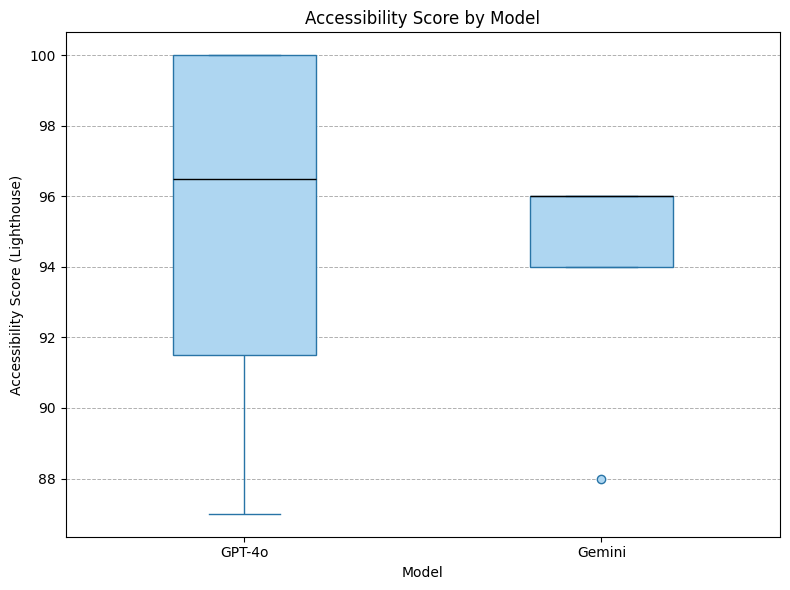

In [93]:
# Estilo visual
sns.reset_defaults()

plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='AccessibilityScore', data=df, width=0.4,
    boxprops=dict(edgecolor=color_borde, facecolor=color_claro),
    medianprops=dict(color=color_negro),
    whiskerprops=dict(color=color_borde),
    capprops=dict(color=color_borde),
    flierprops=dict(markerfacecolor=color_claro, markeredgecolor=color_borde)
)
plt.title('Accessibility Score by Model')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_model.jpg', dpi=300)
plt.show()


#### Axe Issues by Model

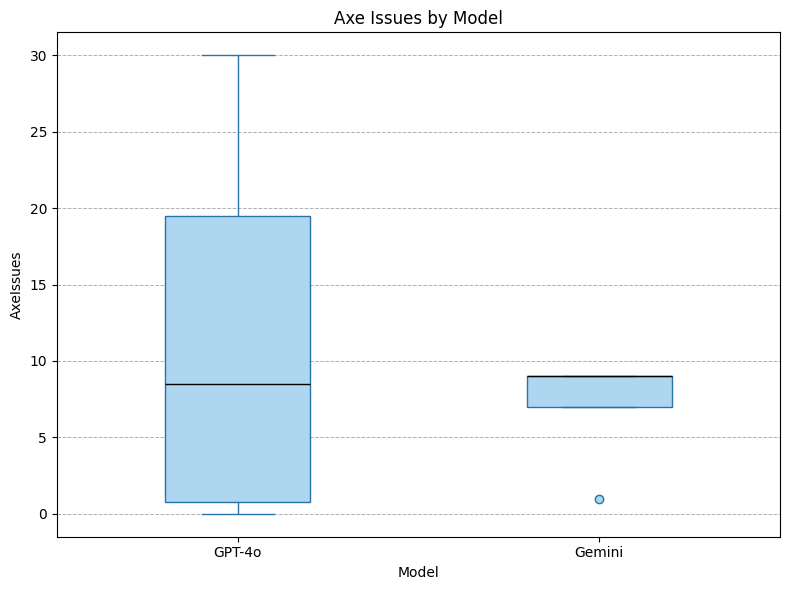

In [94]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='AxeIssues', data=df, width=0.4,
    boxprops=dict(edgecolor=color_borde, facecolor=color_claro),
    medianprops=dict(color=color_negro),
    whiskerprops=dict(color=color_borde),
    capprops=dict(color=color_borde),
    flierprops=dict(markerfacecolor=color_claro, markeredgecolor=color_borde)
)
plt.title('Axe Issues by Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_axeissues_model.jpg', dpi=400)
plt.show()

#### Accessibility Score by Input Type (HTML vs Markdown)

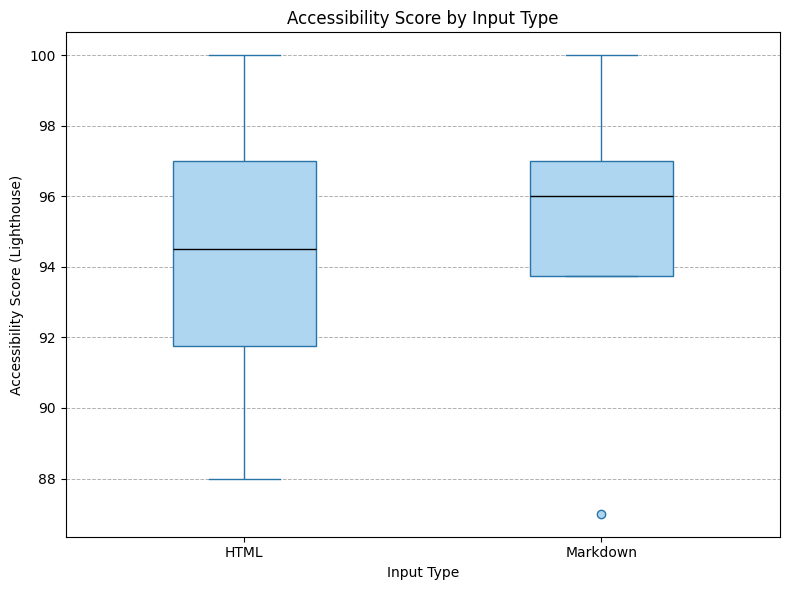

In [95]:
plt.figure(figsize=(8,6))
sns.boxplot(x='InputType', y='AccessibilityScore', data=df, width=0.4,
    boxprops=dict(edgecolor=color_borde, facecolor=color_claro),
    medianprops=dict(color=color_negro),
    whiskerprops=dict(color=color_borde),
    capprops=dict(color=color_borde),
    flierprops=dict(markerfacecolor=color_claro, markeredgecolor=color_borde)
)
plt.title('Accessibility Score by Input Type')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Input Type')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_inputtype.jpg', dpi=300)
plt.show()


#### Accessibility Score by Template Usage

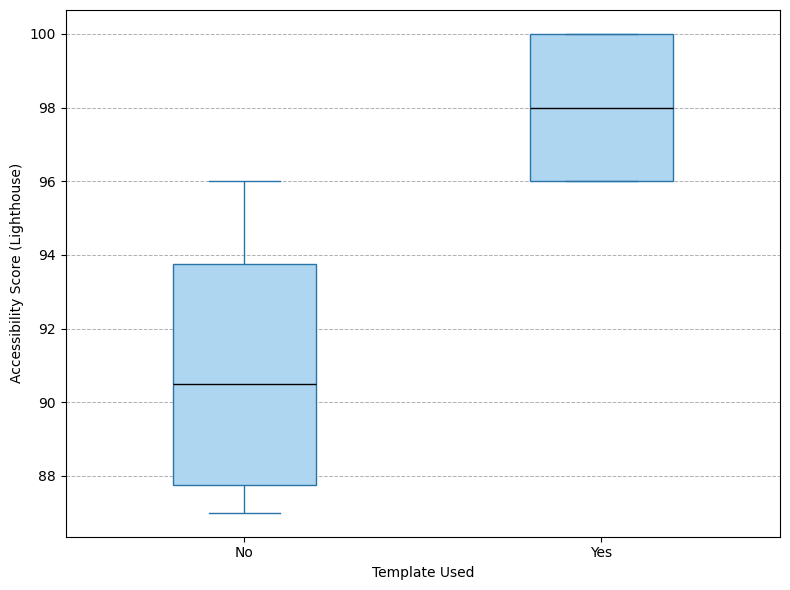

In [96]:
plt.figure(figsize=(8,6))
sns.boxplot(x='TemplateUsed', y='AccessibilityScore', data=df, width=0.4,
    boxprops=dict(edgecolor=color_borde, facecolor=color_claro),
    medianprops=dict(color=color_negro),
    whiskerprops=dict(color=color_borde),
    capprops=dict(color=color_borde),
    flierprops=dict(markerfacecolor=color_claro, markeredgecolor=color_borde)
)
# plt.title('Accessibility Score by Template Usage')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Template Used')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_template.jpg', dpi=300)
plt.show()


### Tokens by model

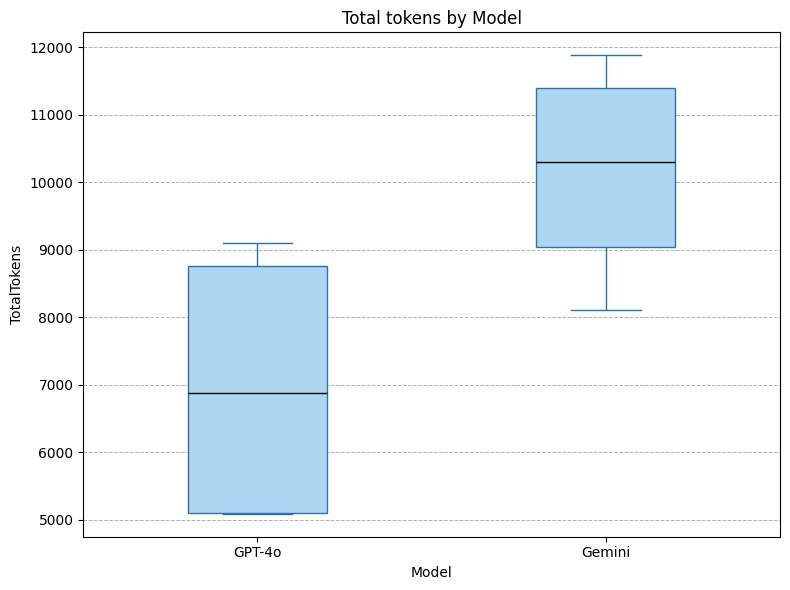

In [97]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='TotalTokens', data=df, width=0.4,
    boxprops=dict(edgecolor=color_borde, facecolor=color_claro),
    medianprops=dict(color=color_negro),
    whiskerprops=dict(color=color_borde),
    capprops=dict(color=color_borde),
    flierprops=dict(markerfacecolor=color_claro, markeredgecolor=color_borde)
)
plt.title('Total tokens by Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_tokens_model.jpg', dpi=300)
plt.show()

### 2. Scatterplots — Correlations


#### 2.1 Prompt tokens vs Accessibility Score

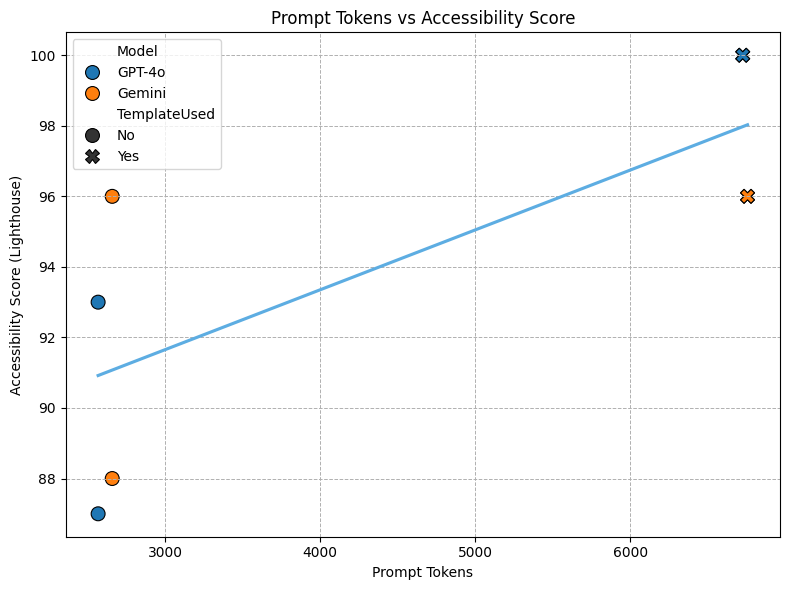

In [100]:
# Crear scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PromptTokens', 
    y='AccessibilityScore', 
    hue='Model', 
    style='TemplateUsed', 
    data=df,
    s=100,
    edgecolor='black',
)

# Añadir línea de tendencia (regresión lineal)
sns.regplot(
    x='PromptTokens', 
    y='AccessibilityScore', 
    data=df, 
    scatter=False, 
    color=color_medio,  # Color personalizado
    ci=None
)

plt.title('Prompt Tokens vs Accessibility Score')
plt.xlabel('Prompt Tokens')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()

# Guardar imagen
plt.savefig('figures/scatter_completiontokens_vs_accessibility.jpg', dpi=300)
plt.show()

#### 2.2 Total Tokens vs Accessibility Score

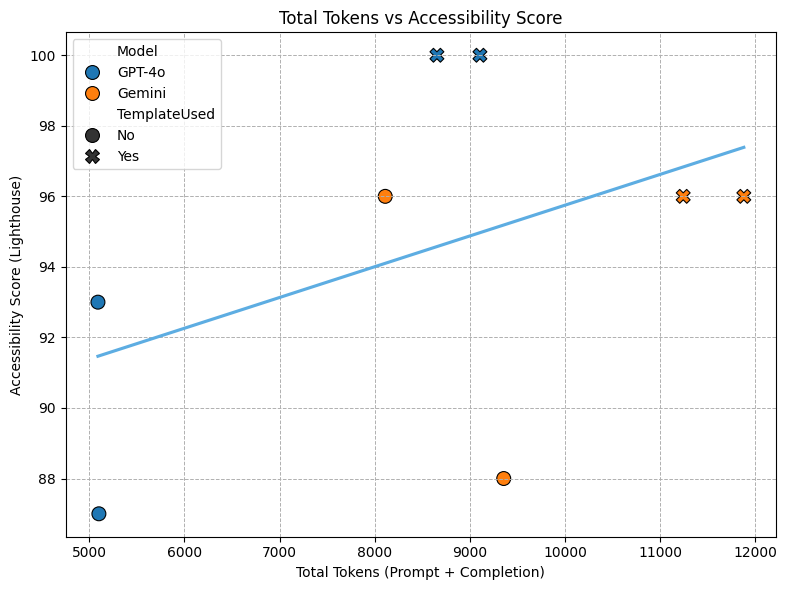

In [76]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='TotalTokens', y='AccessibilityScore', hue=df['Model'], style=df['TemplateUsed'], data=df, s=100, edgecolor='black')
sns.regplot(x='TotalTokens', y='AccessibilityScore', data=df, scatter=False, color=color_medio, ci=None)
plt.title('Total Tokens vs Accessibility Score')
plt.xlabel('Total Tokens (Prompt + Completion)')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_tokens_vs_accessibility.jpg', dpi=300)
plt.show()


#### 2.3 Axe Issues vs Accessibility Score

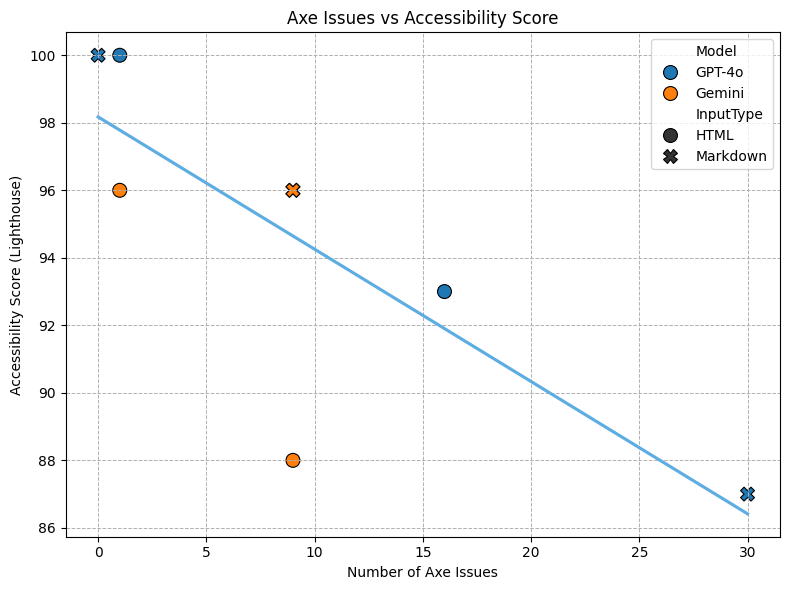

In [77]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='AxeIssues', y='AccessibilityScore', hue=df['Model'], style=df['InputType'], data=df, s=100, edgecolor='black')
sns.regplot(x='AxeIssues', y='AccessibilityScore', data=df, scatter=False, color=color_medio, ci=None)
plt.title('Axe Issues vs Accessibility Score')
plt.xlabel('Number of Axe Issues')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_axeissues_vs_accessibility.jpg', dpi=300)
plt.show()



### 3. Bar Charts — Before and After Comparisons


#### 3.1 Errores WAVE Original vs Mejorados (per site)

In [78]:
import pandas as pd

# Provided dataframe `df` assumed to be already loaded with all metrics
# Compute the generated means grouped by site
generated_metrics = df.groupby('Site')[['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']].mean()

# Build summary table
rows = []
for site in ['Site 1']:
    for metric in ['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']:
        original = original_wave_metrics[site][metric]
        generated = generated_metrics.loc[site, metric]
        if metric == 'WAVEFeatures':
            improvement = ((generated - original) / original) * 100
        else:
            improvement = ((original - generated) / original) * 100
        rows.append({
            'Site': site,
            'Metric': metric.replace('WAVE', ''),
            'Original': original,
            'Generated Mean': round(generated, 2),
            'Improvement (%)': round(improvement, 1)
        })

# Convert to DataFrame
improvement_df = pd.DataFrame(rows)

# Show the result
print(improvement_df)


     Site          Metric  Original  Generated Mean  Improvement (%)
0  Site 1          Errors         9            0.00            100.0
1  Site 1  ContrastErrors        13            4.88             62.5
2  Site 1          Alerts         8            5.25             34.4
3  Site 1        Features         3           10.88            262.5


#### 3.2 WAVE Errors: Original vs Improved (per site)

This bar chart compares the average number of WAVE errors before and after remediation for each site. The results show a significant reduction in detected errors, demonstrating the effectiveness of the LLM-based remediation process.


     Site              Metric       Type   Value
0  Site 1          WAVEErrors   Original   9.000
1  Site 1          WAVEErrors  Generated   0.000
2  Site 1  WAVEContrastErrors   Original  13.000
3  Site 1  WAVEContrastErrors  Generated   4.875
4  Site 1          WAVEAlerts   Original   8.000
5  Site 1          WAVEAlerts  Generated   5.250
6  Site 1        WAVEFeatures   Original   3.000
7  Site 1        WAVEFeatures  Generated  10.875


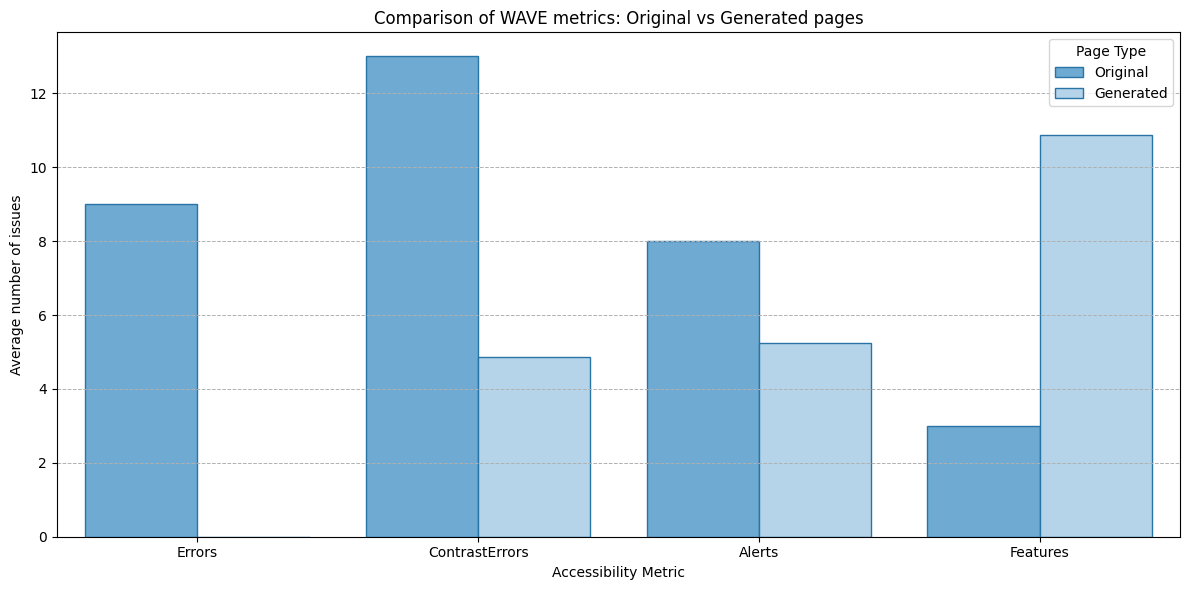

In [101]:
# Promedios de las métricas generadas
generated_metrics = df.groupby('Site')[['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']].mean()

# Estructurar los datos para graficar
data = []
sites = ['Site 1']
metrics = ['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']

for site in sites:
    for metric in metrics:
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Original',
            'Value': original_wave_metrics[site][metric]
        })
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Generated',
            'Value': generated_metrics.loc[site, metric]
        })

compare_df = pd.DataFrame(data)
print(compare_df)

# Remover prefijo 'WAVE' de las etiquetas
compare_df['Metric'] = compare_df['Metric'].str.replace('WAVE', '')

# Gráfica
plt.figure(figsize=(12,6))

# Dibujar las barras manualmente por tipo
palette = {'Original': color_medio, 'Generated': color_claro}
edgecolor = color_borde

sns.barplot(x='Metric', y='Value', hue='Type', data=compare_df, errorbar=None, palette=palette, edgecolor=edgecolor)
plt.title('Comparison of WAVE metrics: Original vs Generated pages')
plt.ylabel('Average number of issues')
plt.xlabel('Accessibility Metric')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Page Type')
plt.tight_layout()
plt.savefig('figures/bar_wave_metrics_comparison.jpg', dpi=300)
plt.show()


#### 3.3 Lighhouse Score: Accessibility Score By Input Type And Model

This bar chart compares the Accessibility Score by input type and model after remediation.

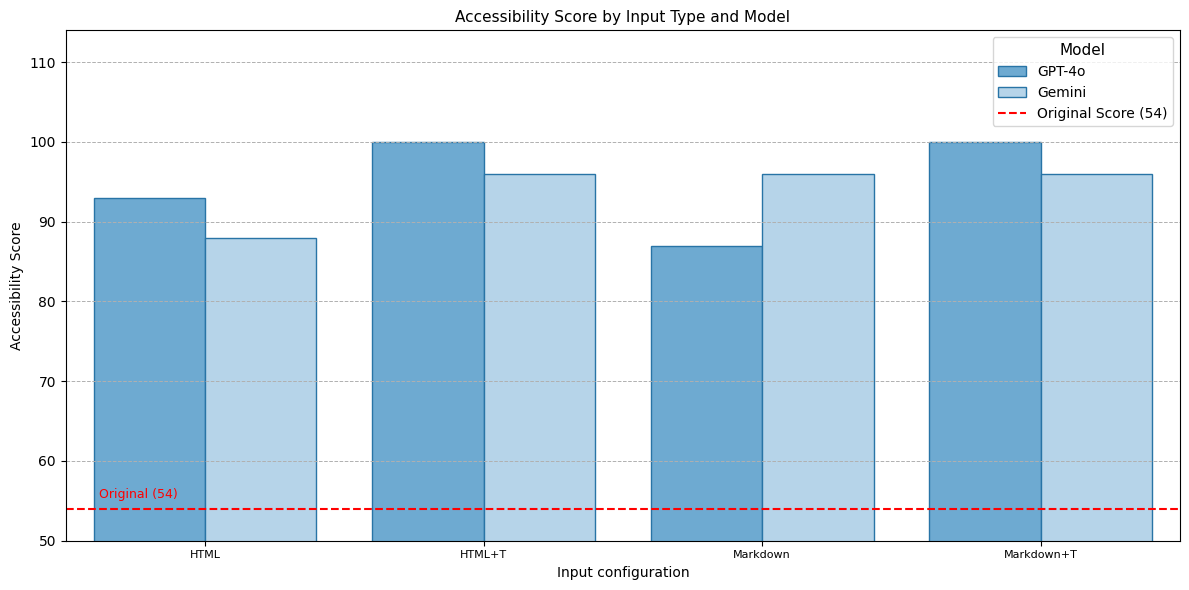

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar columna para eje X
df['Input+Template'] = df['InputType'] + df['TemplateUsed'].map({'Yes': '+T', 'No': ''})

# Crear diccionario de colores por modelo
palette = {'GPT-4o': color_medio, 'Gemini': color_claro}
edgecolor = color_borde  # Color del borde de las barras

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Input+Template', y='AccessibilityScore', hue='Model', palette=palette, edgecolor=edgecolor)

# Agregar línea del score original
plt.axhline(y=54, color=color_rojo, linestyle='--', linewidth=1.5, label='Original Score (54)')
plt.text(-0.38, 55, 'Original (54)', color=color_rojo, fontsize=9, va='bottom')


# Personalización del gráfico
plt.title("Accessibility Score by Input Type and Model", fontsize=11)
plt.ylabel("Accessibility Score")
plt.xlabel("Input configuration")
plt.ylim(50, 114)
plt.xticks(rotation=0, ha='center', fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Model', loc='upper right', fontsize=10, title_fontsize=11)
plt.tight_layout()

# Guardar imagen
plt.savefig("figures/score_comparison_compact.png", dpi=500)
plt.show()


### 3.4 Comparison of Improvement Using the Lighthouse Score

Generates a table with the percentage improvement relative to the original Lighthouse score. This table will later be used to create a heatmap.


In [82]:
def generate_improvement_table(df):

    # Etiquetas ordenadas como columnas
    variant_labels = [
        'GPT-HTML', 'GPT-HTML+T', 'GPT-MD', 'GPT-MD+T',
        'Gem-HTML', 'Gem-HTML+T', 'Gem-MD', 'Gem-MD+T'
    ]

    improvement_table = []

    for site in ['Site 1']:
        row = [site, original_lighthouse_scores[site]]
        for model in ['GPT-4o', 'Gemini']:
            for input_type in ['HTML', 'Markdown']:
                for template in ['No', 'Yes']:
                    score = df[
                        (df['Site'] == site) &
                        (df['Model'] == model) &
                        (df['InputType'] == input_type) &
                        (df['TemplateUsed'] == template)
                    ]['AccessibilityScore'].values[0]
                    original = original_lighthouse_scores[site]
                    improvement = round(((score - original) / original) * 100, 2)
                    row.append(improvement)
        improvement_table.append(row)

    # Mostrar tabla
    header = ['Site', 'Original'] + variant_labels
    print("{:<8} {:<10} ".format(header[0], header[1]) + " ".join(f"{col:<13}" for col in header[2:]))

    for row in improvement_table:
        print("{:<8} {:<10} ".format(row[0], row[1]) + " ".join(f"{val:<13}" for val in row[2:]))
        
generate_improvement_table(df)

Site     Original   GPT-HTML      GPT-HTML+T    GPT-MD        GPT-MD+T      Gem-HTML      Gem-HTML+T    Gem-MD        Gem-MD+T     
Site 1   54         72.22         85.19         61.11         85.19         62.96         77.78         77.78         77.78        


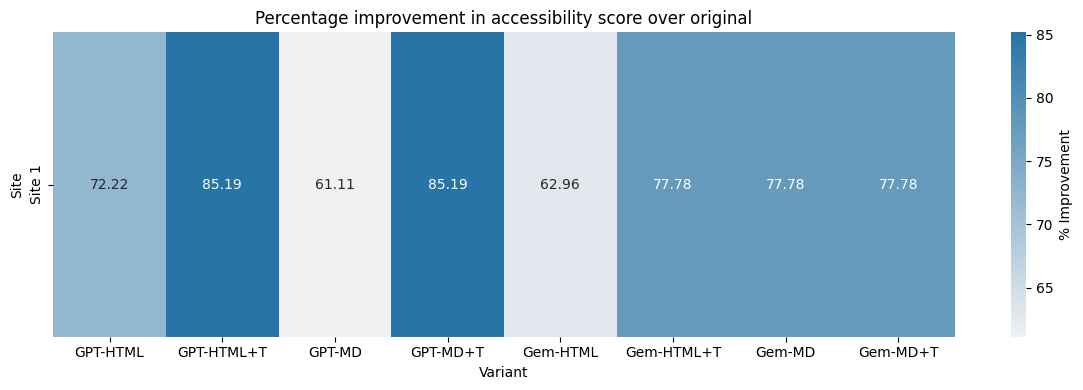

In [104]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def save_improvement_heatmap(df, output_path='figures/heatmap_accessibility_improvement.jpg'):
    # Crear carpeta si no existe
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Etiquetas
    variant_labels = [
        'GPT-HTML', 'GPT-HTML+T', 'GPT-MD', 'GPT-MD+T',
        'Gem-HTML', 'Gem-HTML+T', 'Gem-MD', 'Gem-MD+T'
    ]

    improvement_table = []

    for site in ['Site 1']:
        row = [site, original_lighthouse_scores[site]]
        for model in ['GPT-4o', 'Gemini']:
            for input_type in ['HTML', 'Markdown']:
                for template in ['No', 'Yes']:
                    score = df[
                        (df['Site'] == site) &
                        (df['Model'] == model) &
                        (df['InputType'] == input_type) &
                        (df['TemplateUsed'] == template)
                    ]['AccessibilityScore'].values[0]
                    original = original_lighthouse_scores[site]
                    improvement = round(((score - original) / original) * 100, 2)
                    row.append(improvement)
        improvement_table.append(row)

    # Crear heatmap
    header = ['Site', 'Original'] + variant_labels
    df_plot = pd.DataFrame(improvement_table, columns=header).set_index('Site')
    df_plot = df_plot.drop(columns='Original')

    # Paleta en tonos morado oscuro
    cmap = sns.light_palette(color_borde, as_cmap=True)

    plt.figure(figsize=(12, 4))
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap=cmap, cbar_kws={'label': '% Improvement'})
    plt.title('Percentage improvement in accessibility score over original')
    plt.xlabel('Variant')
    plt.ylabel('Site')
    plt.tight_layout()
    plt.savefig(output_path, format='jpg', dpi=300)
    plt.show()
    plt.close()

save_improvement_heatmap(df)

### Additional: Distribution of Studies After QA


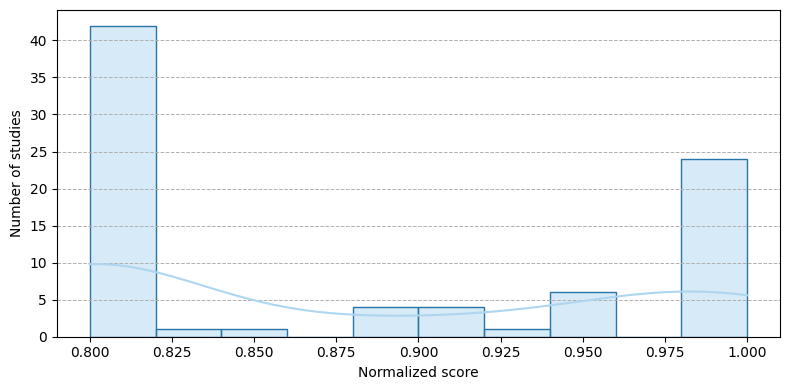

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulamos una lista de puntajes QA sin normalizar
qa_scores = [
    0.95, 0.88, 0.80, 0.80, 0.98, 0.80, 0.80, 0.90, 0.80, 0.80,
    1.00, 0.80, 0.90, 0.98, 1.00, 0.95, 0.80, 0.95, 0.80, 0.95,
    0.80, 0.83, 0.80, 0.80, 0.98, 0.80, 1.00, 0.98, 0.98, 0.80,
    0.80, 0.80, 0.80, 0.80, 0.98, 0.80, 0.80, 0.80, 0.80, 0.80,
    0.80, 0.95, 1.00, 0.80, 0.80, 0.80, 0.80, 0.88, 0.88, 0.80,
    1.00, 1.00, 0.80, 0.80, 0.80, 0.88, 0.80, 0.80, 0.93, 0.98,
    0.80, 1.00, 0.80, 1.00, 0.95, 1.00, 0.80, 0.80, 0.80, 0.98,
    0.90, 0.80, 0.98, 1.00, 0.90, 0.80, 1.00, 0.98, 1.00, 0.98,
    0.80, 0.85, 1.00
]

# Convertimos a DataFrame
qa_df = pd.DataFrame({'NormalizedScore': qa_scores})

# Graficamos la distribución
plt.figure(figsize=(8, 4))
bars = sns.histplot(qa_df['NormalizedScore'], bins=10, kde=True, edgecolor=color_borde, color=color_claro)

# Personalización del gráfico
# plt.title('Distribution of normalized QA scores')
plt.xlabel('Normalized score')
plt.ylabel('Number of studies')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Guardar y mostrar
plt.savefig("figures/qa-distribution.png", dpi=500)
plt.show()
